In [48]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import os
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
# import xgboost as xgb
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Data Cleaning for Housing Listings

This notebook is dedicated to cleaning the housing dataset. The following tasks are performed:
1. Loading the dataset.
5. Renaming columns for clarity.


In [49]:
raw_housing_data = pd.read_csv("data/NEWPrimaryDataset-MLS-RentalProperties.csv") # load the dataset

# Display basic information about the dataset
print(raw_housing_data.shape)
raw_housing_data.info()

# Display the first few rows of the dataset to inspect it
raw_housing_data.head()

(1750, 77)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1750 entries, 0 to 1749
Data columns (total 77 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   List Number                           1750 non-null   object 
 1   Agency Phone                          1737 non-null   object 
 2   Listing Agent                         1750 non-null   object 
 3   Co-Listing Agent                      285 non-null    object 
 4   Property Type                         1750 non-null   object 
 5   Card Format                           1750 non-null   object 
 6   Book Section                          1750 non-null   object 
 7   Property Sub Type                     1750 non-null   object 
 8   Listing Contract Date                 1750 non-null   object 
 9   Back on Market Date                   78 non-null     object 
 10  Status                                1750 non-null   object 
 11  Status

,List Number,Agency Phone,Listing Agent,Co-Listing Agent,Property Type,Card Format,Book Section,Property Sub Type,Listing Contract Date,Back on Market Date,...,Carport Spaces,Non-Representative Compensation,Entry Level,Accessibility Features YN,Unit Type,Comp Sale YN,Price Change Timestamp,Days on Market,Rooms,Features
0,NotAScam123,Agency_Phone_Index_656,Listing_Agent_Index_999,NaN,Rental,Residential Lease,Single Family Residence,SF,9/22/24,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NaN,Ugrent Sale
1,gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...,Agency_Phone_Index_656,Listing_Agent_Index_974,NaN,Rental,Residential Lease,Townhouse,TH,3/2/24,NaN,...,NaN,0.0,1.0,N,NaN,N,NaN,137,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
2,gAAAAABm9wKysBww5tTVmO-0CpaE-LagSeR4KNGjc7knBz...,Agency_Phone_Index_657,Listing_Agent_Index_975,NaN,Rental,Residential Lease,Quadruplex,QU,6/3/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,9/22/24 1:37,65,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...
3,gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...,Agency_Phone_Index_658,Listing_Agent_Index_976,NaN,Rental,Residential Lease,Single Family Residence,SF,6/21/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,15,NaN,Additional Lease Terms|Other|Yes;Deposits and ...
4,gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...,Agency_Phone_Index_659,Listing_Agent_Index_977,NaN,Rental,Residential Lease,Single Family Residence,SF,6/8/24,NaN,...,NaN,0.0,NaN,N,NaN,NaN,NaN,72,NaN,Additional Lease Terms|12 Months|Yes;Deposits ...


In [50]:
relevant_columns = [
    'List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area', 
    'MLS Area Major', 'Year Built', 
    'Lot Size Acres', 'Days on Market', 'Non-Representative Compensation',
    'Waterfront YN', 'Garage YN', 'Stories Total', 'Stories', 'Bedrooms Total', 'Bathrooms Total',
    'Bathrooms Full', 'Bathrooms Half', 'Garage YN', 'Garage Spaces', 'Original List Price', 'Latitude', 'Longitude', 'Rooms', 'Features'
]

numerical_columns = [
    'List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area', 'MLS Area Major', 'Year Built', 'Lot Size Acres', 'Days on Market', 'Non-Representative Compensation',
    'Stories Total', 'Stories', 'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces', 'Original List Price', 'Latitude', 'Longitude'
]

print(len(numerical_columns))

# Drop the irrelevant columns
cleaned_housing_data = raw_housing_data[numerical_columns]

17


In [51]:
# Drop rows with any missing values
cleaned_housing_data = cleaned_housing_data.dropna()

# Check for duplicate columns and remove them
cleaned_housing_data = cleaned_housing_data.loc[:, ~cleaned_housing_data.columns.duplicated()]

# Display the dataset shape and head after these operations
print(cleaned_housing_data.shape)
cleaned_housing_data.info()
cleaned_housing_data.head()

(340, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 25 to 1746
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   List Price                       340 non-null    int64  
 1   Bedrooms Total                   340 non-null    int64  
 2   Bathrooms Total                  340 non-null    int64  
 3   Living Area                      340 non-null    float64
 4   MLS Area Major                   340 non-null    int64  
 5   Year Built                       340 non-null    int64  
 6   Lot Size Acres                   340 non-null    float64
 7   Days on Market                   340 non-null    int64  
 8   Non-Representative Compensation  340 non-null    float64
 9   Stories Total                    340 non-null    float64
 10  Stories                          340 non-null    float64
 11  Bathrooms Full                   340 non-null    int64  
 12  Bathrooms Half 

,List Price,Bedrooms Total,Bathrooms Total,Living Area,MLS Area Major,Year Built,Lot Size Acres,Days on Market,Non-Representative Compensation,Stories Total,Stories,Bathrooms Full,Bathrooms Half,Garage Spaces,Original List Price,Latitude,Longitude
25,1695,2,2,1230.0,26,2008,0.01,55,10.0,2.0,2.0,2,0.0,1.0,1725,30.284262,-81.454856
27,2700,5,2,2498.0,14,1996,0.46,43,0.0,2.0,2.0,2,0.0,2.0,2900,30.156717,-81.629576
38,2500,5,2,1990.0,135,1980,0.27,53,100.0,1.0,1.0,2,0.0,2.0,2600,30.160414,-81.744717
40,4425,3,3,2442.0,43,2012,0.10,23,1.0,2.0,2.0,2,1.0,2.0,4425,30.341041,-81.461648
41,4500,3,2,1426.0,212,1979,0.14,21,1.0,2.0,2.0,2,0.0,1.0,4500,30.266153,-81.398813


In [52]:
# File path to save the CSV
file_path = 'data/cleaned_housing_data.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    cleaned_housing_data.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")
else:
    print(f"File {file_path} already exists. No action taken.")

File data/cleaned_housing_data.csv already exists. No action taken.



# Principal Component Analysis (PCA) and Anomaly Detection

In this section, we apply PCA for dimensionality reduction and anomaly detection on housing data.
We will retain 95% of variance and also explore anomaly detection using DBSCAN and Isolation Forest.

---

### Step 1: Fit PCA and Transform the Data
Here, we fit PCA to the scaled dataset and retain 95% of the variance.

In [53]:
# Step 1: Fit the PCA (retaining 95% of variance)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(cleaned_housing_data)

print(x_scaled.shape)
pca_model = PCA(n_components=0.95)
x_pca = pca_model.fit_transform(x_scaled)  # 'x_scaled' is the scaled input data

(340, 17)



### Step 2: Create a DataFrame for the Principal Components

We create a DataFrame that contains the principal components for each data point.
Each component captures the variance in the original features.


In [54]:

# Create column names for PCA components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]

# Create a DataFrame for the PCA-transformed data
pca_df = pd.DataFrame(x_pca, columns=pca_columns)
pca_df.head()

model1 = IsolationForest(n_estimators=100, max_samples='auto', contamination='auto', random_state=12)

model1.fit(x_pca)

predict = model1.predict(x_pca)
anomalies = x_scaled[predict == -1]

(17, 13)
17


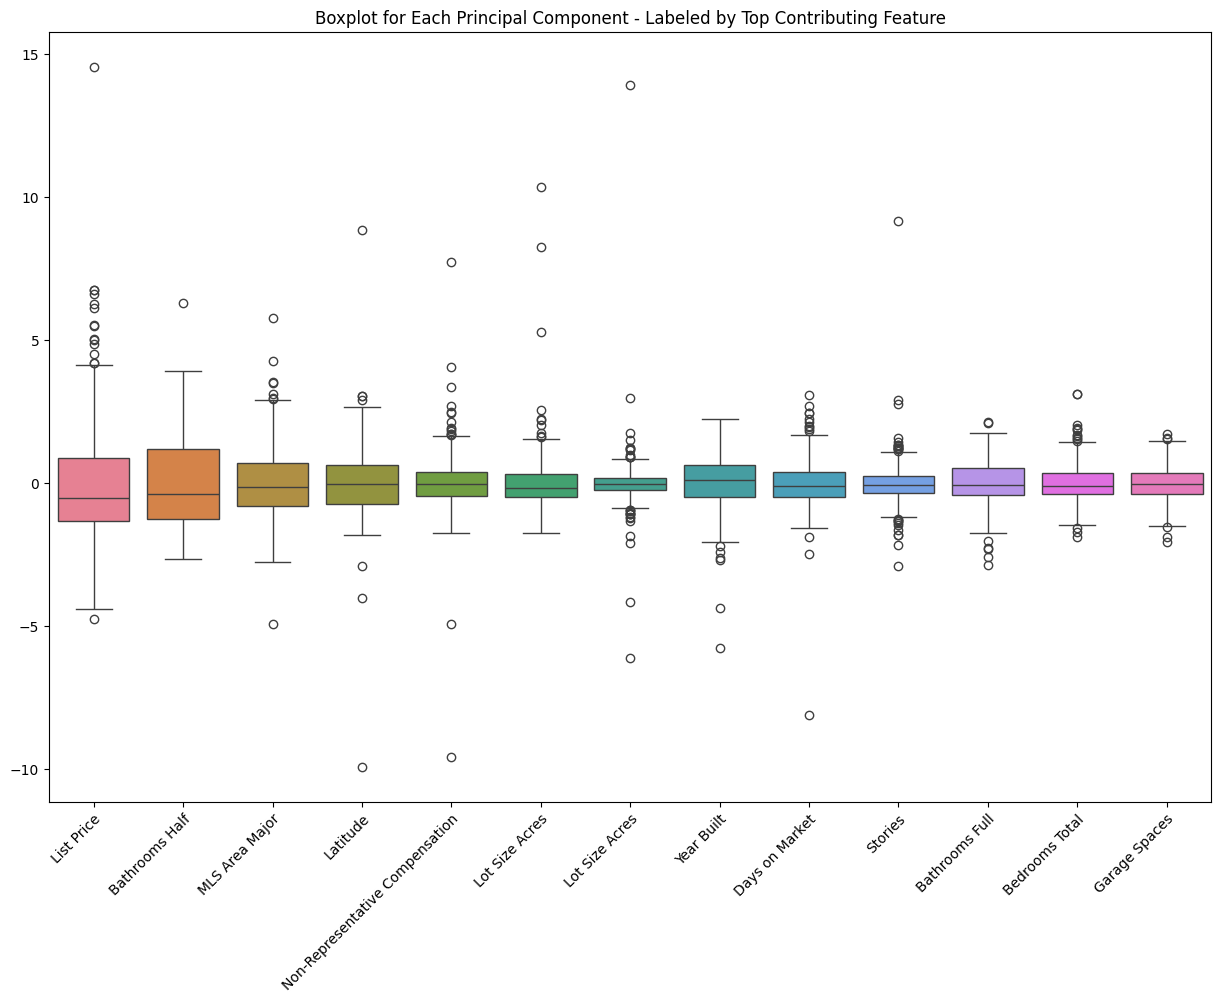

In [55]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])] 
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
print(loadings.shape)
print(len(numerical_columns))
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)


# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Create a box plot and label each principal component by its strongest contributing original feature
plt.figure(figsize=(15, 10))
sns.boxplot(data=pca_df)

# Rotate the text diagonally and align it so it reads from top to bottom
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Boxplot for Each Principal Component - Labeled by Top Contributing Feature')
plt.show()

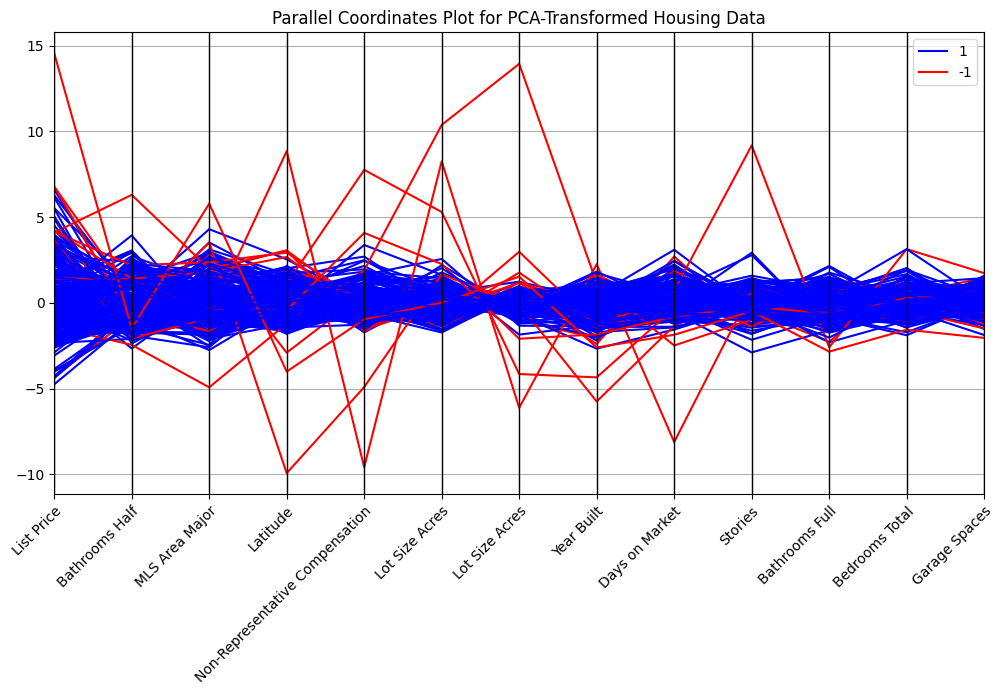

In [56]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)

# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Add anomaly labels to the PCA DataFrame
pca_df['anomaly'] = predict  # Anomalies (-1) and normal points (1)

# Step 6: Parallel Coordinates Plot with PCA data and anomaly labels
plt.figure(figsize=(12, 6))
parallel_coordinates(pca_df, 'anomaly', color=['blue', 'red'])

# Step 7: Adjust the x-axis labels (principal components) with top contributing original feature names
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Parallel Coordinates Plot for PCA-Transformed Housing Data')
plt.show()

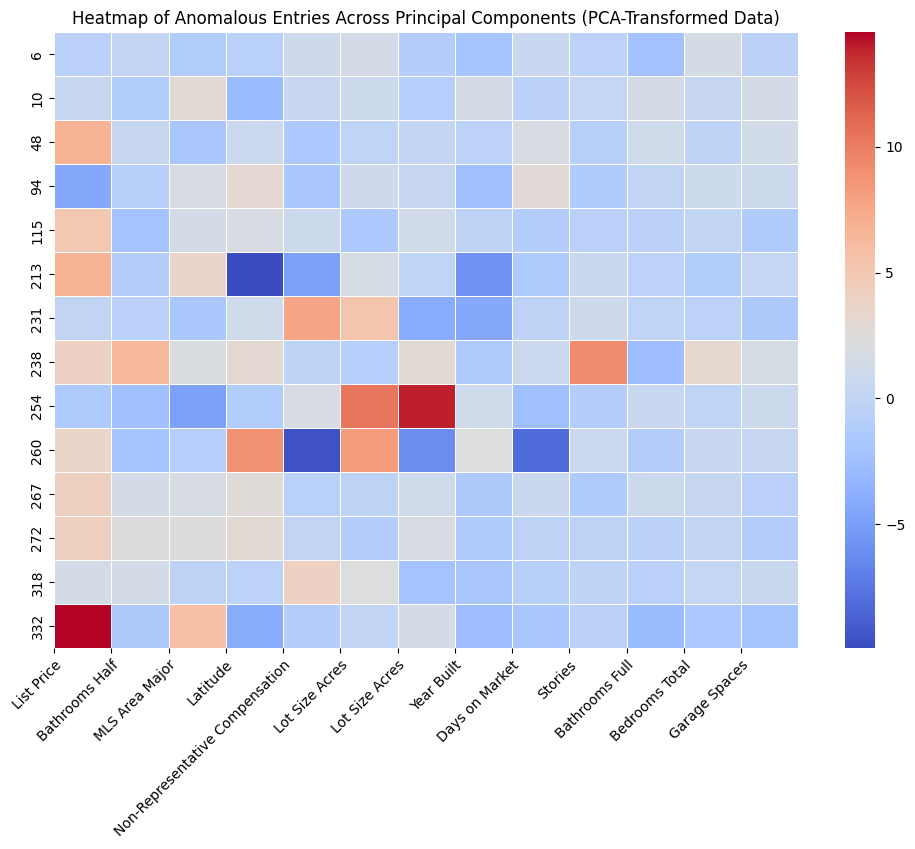

In [57]:
# Step 1: Fit the PCA as before
pca = PCA(n_components=0.95)  # Retaining 95% of variance
x_pca = pca.fit_transform(x_scaled)

# Step 2: Create a DataFrame for the principal components
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]
pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 3: Get the contributions of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numerical_columns, columns=pca_columns)

# Step 4: Get the top contributing feature for each principal component (for labeling purposes)
top_features_per_pc = contributions_df.abs().idxmax()

# Step 5: Filter the PCA data to show only anomalies (-1)
anomalous_data = pca_df[predict == -1]

# Step 6: Plot a heatmap of the anomalous entries (use PCA-transformed data)
plt.figure(figsize=(12, 8))
sns.heatmap(anomalous_data, cmap='coolwarm', annot=False, linewidths=0.5)

# Step 7: Adjust x-axis labels to reflect original features (diagonal or vertical)
plt.xticks(range(len(top_features_per_pc)), top_features_per_pc, rotation=45, ha="right", rotation_mode="anchor")

# Title
plt.title('Heatmap of Anomalous Entries Across Principal Components (PCA-Transformed Data)')
plt.show()

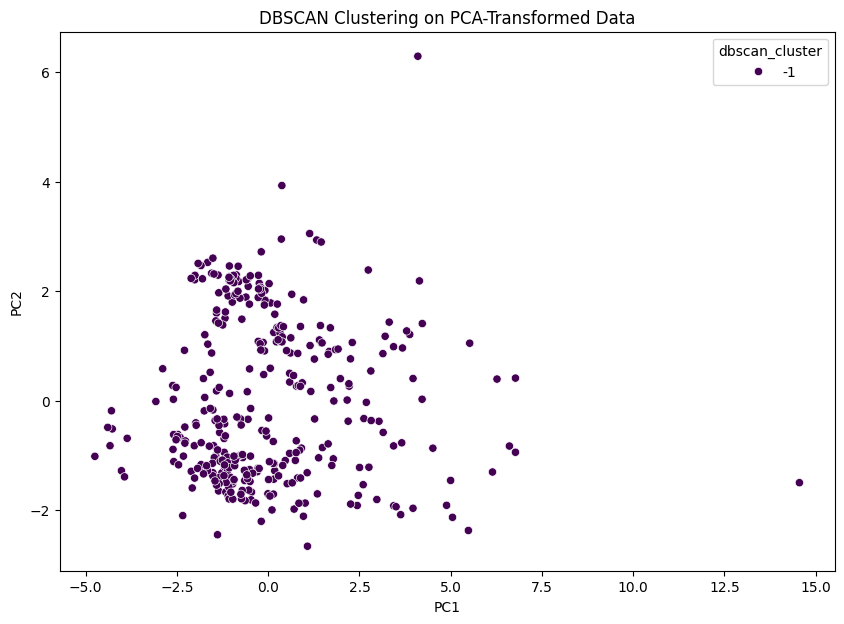

Number of points flagged by both DBSCAN and Isolation Forest: 0


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,dbscan_cluster,anomaly_iforest


In [58]:
# Step 1: Fit DBSCAN on the PCA-transformed data
dbscan_model = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your data
dbscan_labels = dbscan_model.fit_predict(x_pca)

# Step 2: Add DBSCAN cluster labels to the PCA DataFrame
pca_df['dbscan_cluster'] = dbscan_labels

# Step 3: Visualize the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=pca_df['dbscan_cluster'], palette='viridis')
plt.title('DBSCAN Clustering on PCA-Transformed Data')
plt.show()

# Step 4: Cross-examine DBSCAN clusters with Isolation Forest results
pca_df['anomaly_iforest'] = predict  # Add Isolation Forest anomaly labels (-1 for anomalies, 1 for normal)

# Compare clusters and anomalies
cross_examined = pca_df[(pca_df['dbscan_cluster'] != -1) & (pca_df['anomaly_iforest'] == -1)]

print(f"Number of points flagged by both DBSCAN and Isolation Forest: {len(cross_examined)}")
cross_examined

In [59]:
# Add the Under_30_Days_Flag (1 = 30 days or less, 0 = more than 30 days)
cleaned_housing_data['Under_30_Days_Flag'] = cleaned_housing_data['Days on Market'].apply(lambda x: 1 if x <= 30 else 0)

# Save the updated dataset to a new CSV file with a better file name
file_path = 'data/housing_data_under_30_days_flag.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    cleaned_housing_data.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")
else:
    print(f"File {file_path} already exists. No action taken.")

# Verify the first few rows of the updated dataset
print(cleaned_housing_data[['Days on Market', 'Under_30_Days_Flag']].head(10))


File data/housing_data_under_30_days_flag.csv already exists. No action taken.
    Days on Market  Under_30_Days_Flag
25              55                   0
27              43                   0
38              53                   0
40              23                   1
41              21                   1
44               7                   1
45              48                   0
47              94                   0
52              36                   0
55               0                   1


In [60]:
import folium
from folium.plugins import HeatMap
from math import radians, cos, sin, asin, sqrt, log

# Important locationations for proximity scoring
important_coordinates = [
    {"name": "University of North Florida", "latitude": 30.2715, "longitude": -81.5094, "weight": 0.7727},  # Jacksonville, Duval County
    {"name": "Flagler College", "latitude": 29.8947, "longitude": -81.3145, "weight": 0.1182},  # St. Augustine, St. Johns County
    {"name": "St. Johns River State College", "latitude": 29.6486, "longitude": -81.6417, "weight": 0.2955},  # Palatka, Putnam County
    {"name": "Edward Waters University", "latitude": 30.3422, "longitude": -81.6794, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Concorde Career Institute", "latitude": 30.3374, "longitude": -81.5546, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "First Coast Technical College", "latitude": 29.8922, "longitude": -81.3305, "weight": 0.0182},  # St. Augustine, St. Johns County
    {"name": "Jacksonville University", "latitude": 30.3532, "longitude": -81.6068, "weight": 0.2045},  # Jacksonville, Duval County
    {"name": "Jones Technical Institute", "latitude": 30.2449, "longitude": -81.5322, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Tulsa Welding School", "latitude": 30.3385, "longitude": -81.5637, "weight": 0.0136},  # Jacksonville, Duval County
    {"name": "Chamberlain University-Florida", "latitude": 30.2598, "longitude": -81.5904, "weight": 0.0409},  # Jacksonville, Duval County
    {"name": "Fortis College-Orange Park", "latitude": 30.1785, "longitude": -81.7079, "weight": 0.0318},  # Orange Park, Clay County
    {"name": "Florida State College at Jacksonville", "latitude": 30.3322, "longitude": -81.6557, "weight": 1.0000},  # Jacksonville, Duval County
    {"name": "Trinity Baptist College", "latitude": 30.2395, "longitude": -81.7802, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "Keiser University", "latitude": 30.3326, "longitude": -81.6562, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Heritage Institute", "latitude": 30.2033, "longitude": -81.5837, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Embry-Riddle Aeronautical University", "latitude": 29.1880, "longitude": -81.0479, "weight": 0.4091},  # Daytona Beach, Volusia County
    {"name": "Naval Air Station Jacksonville", "latitude": 30.2358, "longitude": -81.6800, "weight": 0.9545},  # Jacksonville, Duval County
    {"name": "Naval Station Mayport", "latitude": 30.3915, "longitude": -81.4245, "weight": 0.5455},  # Jacksonville, Duval County
    {"name": "Camp Blanding Joint Training Center", "latitude": 29.9693, "longitude": -81.9840, "weight": 0.6818},  # Clay County
    {"name": "Marine Corps Blount Island Command", "latitude": 30.4111, "longitude": -81.5059, "weight": 0.1364},  # Jacksonville, Duval County
]

# Haversine formula to calculate the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c  # Radius of Earth in kilometers
    return km

# Function to calculate suspicion score based on proximity to important locationations
def calculate_weighted_suspiciousness(row, important_locationations):
    listing_lat = row['Latitude']
    listing_lon = row['Longitude']
    
    total_suspiciousness = 0
    max_distance = 50  # Reasonable commuting distance
    
    for location in important_locationations:
        dist = haversine(listing_lat, listing_lon, location['latitude'], location['longitude'])
        
        if dist <= max_distance:
            location_suspiciousness = location['weight'] * (1 / (log(dist + 1) + 1))
            total_suspiciousness += location_suspiciousness
    
    return total_suspiciousness

# Apply the suspicion calculation to each listing in the dataset
cleaned_housing_data['Distance Suspiciousness'] = cleaned_housing_data.apply(lambda row: calculate_weighted_suspiciousness(row, important_coordinates), axis=1)

# Filter out rows where latitude or longitude is missing
filtered_data = cleaned_housing_data[['Latitude', 'Longitude', 'Distance Suspiciousness']].dropna()

# Create a map centered around Duval County
m = folium.Map(locationation=[30.3322, -81.6557], zoom_start=10)

# Create a list of coordinates and weights (suspicion scores) for the heatmap
heatmap_data = [[row['Latitude'], row['Longitude'], row['Distance Suspiciousness']] for index, row in filtered_data.iterrows()]

# Add the heatmap layer with suspicion scores
HeatMap(heatmap_data, max_value=1, radius=15, blur=10).add_to(m)

# Save the map to an HTML file
m.save('suspicion_score_heatmap.html')

# If running in a notebook, display the map inline
m

In [61]:
important_coordinates = [
    # Colleges and universities are assigned weights based on their student population, 
    # normalized against the largest population in this list (Florida State College at Jacksonville with 22,000 students).
    {"name": "University of North Florida", "latitude": 30.2715, "longitude": -81.5094, "weight": 0.7727},  # Jacksonville, Duval County
    {"name": "Flagler College", "latitude": 29.8947, "longitude": -81.3145, "weight": 0.1182},  # St. Augustine, St. Johns County
    {"name": "St. Johns River State College", "latitude": 29.6486, "longitude": -81.6417, "weight": 0.2955},  # Palatka, Putnam County
    {"name": "Edward Waters University", "latitude": 30.3422, "longitude": -81.6794, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Concorde Career Institute", "latitude": 30.3374, "longitude": -81.5546, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "First Coast Technical College", "latitude": 29.8922, "longitude": -81.3305, "weight": 0.0182},  # St. Augustine, St. Johns County
    {"name": "Jacksonville University", "latitude": 30.3532, "longitude": -81.6068, "weight": 0.2045},  # Jacksonville, Duval County
    {"name": "Jones Technical Institute", "latitude": 30.2449, "longitude": -81.5322, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Tulsa Welding School", "latitude": 30.3385, "longitude": -81.5637, "weight": 0.0136},  # Jacksonville, Duval County
    {"name": "Chamberlain University-Florida", "latitude": 30.2598, "longitude": -81.5904, "weight": 0.0409},  # Jacksonville, Duval County
    {"name": "Fortis College-Orange Park", "latitude": 30.1785, "longitude": -81.7079, "weight": 0.0318},  # Orange Park, Clay County
    {"name": "Florida State College at Jacksonville", "latitude": 30.3322, "longitude": -81.6557, "weight": 1.0000},  # Jacksonville, Duval County (Largest population: 22,000 students)
    {"name": "Trinity Baptist College", "latitude": 30.2395, "longitude": -81.7802, "weight": 0.0227},  # Jacksonville, Duval County
    {"name": "Keiser University", "latitude": 30.3326, "longitude": -81.6562, "weight": 0.0455},  # Jacksonville, Duval County
    {"name": "Heritage Institute", "latitude": 30.2033, "longitude": -81.5837, "weight": 0.0182},  # Jacksonville, Duval County
    {"name": "Embry-Riddle Aeronautical University", "latitude": 29.1880, "longitude": -81.0479, "weight": 0.4091},  # Daytona Beach, Volusia County
    
    # Military bases have their weights calculated based on a combination of permanent and transient personnel. 
    # We estimate the size of the population the base supports and normalize it against the highest value.
    {"name": "Naval Air Station Jacksonville", "latitude": 30.2358, "longitude": -81.6800, "weight": 0.9545},  # Jacksonville, Duval County
    {"name": "Naval Station Mayport", "latitude": 30.3915, "longitude": -81.4245, "weight": 0.5455},  # Jacksonville, Duval County
    {"name": "Camp Blanding Joint Training Center", "latitude": 29.9693, "longitude": -81.9840, "weight": 0.6818},  # Clay County
    {"name": "Marine Corps Blount Island Command", "latitude": 30.4111, "longitude": -81.5059, "weight": 0.1364},  # Jacksonville, Duval County
]

from math import radians, cos, sin, asin, sqrt, log

# Haversine function
def haversine(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * asin(sqrt(a))
    km = 6371 * c  # Earth radius in kilometers
    return km

# Adjusted suspiciousness calculation
def calculate_weighted_suspiciousness(row, important_locationations, max_distance=50, scaling_factor=1):
    listing_lat = row['Latitude']
    listing_lon = row['Longitude']
    
    # Initialize the suspiciousness score
    total_suspiciousness = 0
    baseline_suspiciousness = 0.05  # To account for listings too far from important locationations
    
    # Loop through important locationations and compute suspiciousness
    for location in important_locationations:
        dist = haversine(listing_lat, listing_lon, location['latitude'], location['longitude'])
        
        # Only compute suspiciousness for distances within the max limit
        if dist <= max_distance:
            # Apply scaling factor to dampen the effect of distance logarithmically
            location_suspiciousness = location['weight'] * (1 / (log(dist + 1) + scaling_factor))
            total_suspiciousness += location_suspiciousness
    
    # Add baseline score if total suspiciousness is very low
    total_suspiciousness = max(baseline_suspiciousness, total_suspiciousness)
    
    return total_suspiciousness

# Apply the function to each row and create a new column 'Distance Suspiciousness'
cleaned_housing_data['Distance Suspiciousness'] = cleaned_housing_data.apply(lambda row: calculate_weighted_suspiciousness(row, important_coordinates), axis=1)
cleaned_housing_data['Distance Suspiciousness'].describe()

count    340.000000
mean       1.042194
std        0.177844
min        0.050000
25%        0.965197
50%        1.080173
75%        1.130985
max        1.417022
Name: Distance Suspiciousness, dtype: float64

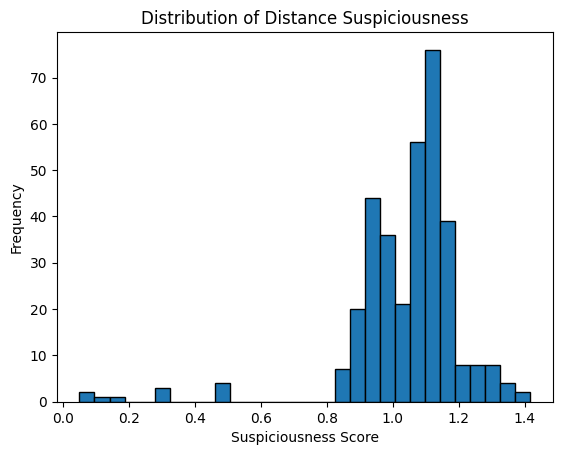

In [62]:
plt.hist(cleaned_housing_data['Distance Suspiciousness'], bins=30, edgecolor='black')
# Add titles and labels
plt.title('Distribution of Distance Suspiciousness')
plt.xlabel('Suspiciousness Score')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [63]:
# Check for duplicate column names
print("Checking for duplicate column names...")
if cleaned_housing_data.columns.duplicated().any():
    print("Duplicate columns detected:")
    # Get a list of all columns with duplicates
    duplicate_columns = cleaned_housing_data.columns[cleaned_housing_data.columns.duplicated()].tolist()
    print("Duplicate columns:", duplicate_columns)
    
    # Remove duplicates by dropping the duplicated columns
    cleaned_housing_data = cleaned_housing_data.location[:, ~cleaned_housing_data.columns.duplicated()]
    print("Duplicate columns removed. Proceeding with the calculation.")
else:
    print("No duplicate columns found. Proceeding with the calculation.")

Checking for duplicate column names...
No duplicate columns found. Proceeding with the calculation.


In [64]:

housing_data_ratios = cleaned_housing_data.copy()

In [90]:
'''# Create a new dataframe with calculated columns
df_price_metrics = pd.DataFrame()

# Assuming 'List Price', 'Bedrooms Total', 'Bathrooms Full', 'Bathrooms Total', 'Stories', 'Garage Spaces', 'Living Area', 'Lot Size Acres', 'Year Built' columns exist in your dataset

df_price_metrics['Price per Bedroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bedrooms Total']
df_price_metrics['Price per Full Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Full']
df_price_metrics['Price per Total Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Total']
df_price_metrics['Price per Story'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Stories']
df_price_metrics['Price per Garage Space'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Garage Spaces']
df_price_metrics['Price per Living Area'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Living Area']
df_price_metrics['Price per Lot Size Acre'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Lot Size Acres']
df_price_metrics['Price per Year Built'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Year Built']

# Display the first few rows of the new dataframe
df_price_metrics.head()'''

# Create a new dataframe with calculated columns
df_price_metrics = pd.DataFrame()

# Calculate price metrics using natural logarithm
df_price_metrics['Price per Bedroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bedrooms Total']
df_price_metrics['Price per Full Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Full']
df_price_metrics['Price per Total Bathroom'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Bathrooms Total']
df_price_metrics['Price per Story'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Stories']
df_price_metrics['Price per Garage Space'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Garage Spaces']
df_price_metrics['Price per Living Area'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Living Area']
df_price_metrics['Price per Lot Size Acre'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Lot Size Acres']
df_price_metrics['Price per Year Built'] = cleaned_housing_data['List Price'] / cleaned_housing_data['Year Built']

# Display the first few rows of the new dataframe
df_price_metrics.head()



,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
25,847.5,847.5,847.5,847.5,1695.0,1.378049,169500.000000,0.844124
27,540.0,1350.0,1350.0,1350.0,1350.0,1.080865,5869.565217,1.352705
38,500.0,1250.0,1250.0,2500.0,1250.0,1.256281,9259.259259,1.262626
40,1475.0,2212.5,1475.0,2212.5,2212.5,1.812039,44250.000000,2.199304
41,1500.0,2250.0,2250.0,2250.0,4500.0,3.155680,32142.857143,2.273876


In [91]:
df_price_metrics['Price per Story'].fillna(cleaned_housing_data['List Price'], inplace=True)

# Handle Garage Spaces: Instead of 0, fill NaN with the median value
df_price_metrics['Price per Garage Space'].fillna(df_price_metrics['Price per Garage Space'].median(), inplace=True)

# Replace infinity for Price per Acre with the median value
df_price_metrics['Price per Lot Size Acre'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_price_metrics['Price per Lot Size Acre'].fillna(df_price_metrics['Price per Lot Size Acre'].median(), inplace=True)

df_price_metrics.fillna(df_price_metrics.median(), inplace=True)

df_price_metrics.head()

/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_20426/2848782618.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_price_metrics['Price per Story'].fillna(cleaned_housing_data['List Price'], inplace=True)
/var/folders/t5/ksv476hn4cq52bmfy8685cnh0000gn/T/ipykernel_20426/2848782618.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediat

,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
25,847.5,847.5,847.5,847.5,1695.0,1.378049,169500.000000,0.844124
27,540.0,1350.0,1350.0,1350.0,1350.0,1.080865,5869.565217,1.352705
38,500.0,1250.0,1250.0,2500.0,1250.0,1.256281,9259.259259,1.262626
40,1475.0,2212.5,1475.0,2212.5,2212.5,1.812039,44250.000000,2.199304
41,1500.0,2250.0,2250.0,2250.0,4500.0,3.155680,32142.857143,2.273876


In [92]:
df_price_metrics


,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built
25,847.5,847.5,847.500000,847.5,1695.0,1.378049,169500.000000,0.844124
27,540.0,1350.0,1350.000000,1350.0,1350.0,1.080865,5869.565217,1.352705
38,500.0,1250.0,1250.000000,2500.0,1250.0,1.256281,9259.259259,1.262626
40,1475.0,2212.5,1475.000000,2212.5,2212.5,1.812039,44250.000000,2.199304
41,1500.0,2250.0,2250.000000,2250.0,4500.0,3.155680,32142.857143,2.273876
...,...,...,...,...,...,...,...,...
1728,700.0,700.0,466.666667,700.0,1400.0,1.190476,35000.000000,0.698254
1729,800.0,1200.0,1200.000000,2400.0,1200.0,1.295896,13333.333333,1.199400
1731,650.0,1300.0,866.666667,1300.0,1300.0,1.277641,15294.117647,1.286492
1733,810.0,810.0,540.000000,810.0,1620.0,1.203566,32400.000000,0.807577


In [93]:
# Step 1: Filter the dataset for relevant columns (replace with actual column names if needed)
df_phone_name = raw_housing_data[['Listing Agent', 'Agency Phone']]

# Step 2: Group by 'Phone Number' and aggregate the unique 'Agent Name' values
duplicates = df_phone_name.groupby('Agency Phone')['Listing Agent'].nunique()

# Step 3: Filter for phone numbers that are associated with more than one unique agent name
suspicious_numbers = duplicates[duplicates > 1]

# Step 4: Flag listings that contain suspicious phone numbers
def flag_suspicious_phone(row):
    if row['Agency Phone'] in suspicious_numbers.index:
        return 1  # Flag as suspicious
    return 0  # Not suspicious

# Step 5: Apply the function to the raw_housing_data DataFrame
raw_housing_data['is_phone_suspicious'] = raw_housing_data.apply(flag_suspicious_phone, axis=1)

# Step 6: Display flagged listings
suspicious_phone_listings = raw_housing_data[raw_housing_data['is_phone_suspicious'] == 1]
print(suspicious_phone_listings)


                                            List Number  \
0                                           NotAScam123   
1     gAAAAABm9wKyQ9Jkf67wT775NlUCIiB2uBl4wESoZ5GvSi...   
3     gAAAAABm9wKyuy2g6q3NVvgVVN2exdWKr-5NmAsg3RNetA...   
4     gAAAAABm9wKybWr-f_0vG4kOlej1Gw_MwtKb3AMZPFNdte...   
8     gAAAAABm9wKyPcWtduVoEXOZ5M5vr1Yn80hjl7PyVBwysX...   
...                                                 ...   
1745  gAAAAABm9wKyrp6dInLa9fa_893eIkk84gRpa6CRHjPCkh...   
1746  gAAAAABm9wKy_Kh_pxh7FOqfUuzhjUAQuSn4K3cfqHvILr...   
1747  gAAAAABm9wKycimdSXA6Mugv0dDA2YGsM2ecai7lGVBfhS...   
1748  gAAAAABm9wKyRw3x6BA06to2n3N-gzrqibmxQCGmG-BK0w...   
1749  gAAAAABm9wKyBFTF5ps5FCcCWCsItB-deJTcWkDDD8p3s5...   

                Agency Phone             Listing Agent  \
0     Agency_Phone_Index_656   Listing_Agent_Index_999   
1     Agency_Phone_Index_656   Listing_Agent_Index_974   
3     Agency_Phone_Index_658   Listing_Agent_Index_976   
4     Agency_Phone_Index_659   Listing_Agent_Index_977   
8

In [94]:
suspicious_words = [
    'urgent', 'alert', 'wire transfer', 'guaranteed', 'free',
    'cash only', 'as seen on', 'limited time', 'don’t miss out',
    'risk-free', 'act now', 'exclusive', 'once in a lifetime',
   'contact now', 'no credit check', 'easy approval','Foreclosure',
     "no deposit required", "move-in specials", "free month rent", "lease takeover", "rent-to-own", 
    "pre-approval needed", "urgent rental", "hurry, limited time offer", "cash only, no checks", 
    "first month free", "no background check", "instant approval", "no credit history needed", 
    "temporary housing", "assume the lease", "short-term rental", "virtual tour only", 
    "sublease opportunity", "guaranteed approval", "utilities included", "all bills paid", 
   "no application fee", "get approved today", "house sitting", "unbelievably low rent", 
    "no lease required", "instant income", "non-refundable deposit", "limited properties available", 
    "you won't believe the price", "exclusive listings", "flexible terms", "unforeseen circumstances", 
    "background check waived", "contact immediately", "first come, first served", "urgent need to rent", 
    "newly renovated", "don’t get left out", "act fast before it’s gone", "scam-free guarantee", 
    "friendly landlord", "best value rental", "quick approval process", "no hassle, no fees", 
    "all-inclusive rental", "hidden gem", "affordable living", "ideal for students", 
    "rent today, move in tomorrow"
]

def flag_suspicious_listings(row):
    # Join relevant columns into one text
    text = f"{row['Features']}".lower()  # Combine and convert to lowercase
    # Check for suspicious words
    for word in suspicious_words:
        if word in text:
            return 1  # Flag as suspicious
    return 0  # Not suspicious

# Assuming Features is the column to check
raw_housing_data['is_suspicious'] = raw_housing_data.apply(flag_suspicious_listings, axis=1)

# Display flagged listings
suspicious_listings = raw_housing_data[raw_housing_data['is_suspicious'] == 1]
print(suspicious_listings)

                                            List Number  \
9     gAAAAABm9wKyhUIXEwyFhhLvpTj0X_0B7qvS_yNAKBOgp6...   
13    gAAAAABm9wKyK87znXWEhuNIwi-d9ktEm5eB_AviuYuh8R...   
15    gAAAAABm9wKyt18LTPCqp5hSIgJ5zQ2R93tF4LryJsQVc-...   
49    gAAAAABm9wKy3YMA1sFaFsJBF53Eg5oOcZbyNvw-1-fcxL...   
59    gAAAAABm9wKyvtOOj5IGCZOf0qG5NqpcUkBxvFxajObtzH...   
...                                                 ...   
1643  gAAAAABm9wKyfVIPxb2l5IFUrCBGl7LR8FjyRb4apyhvvb...   
1695  gAAAAABm9wKyks0AoDGGzVnXjBnx_7KWNBy1zrSb6HYN-0...   
1700  gAAAAABm9wKyWBcFWFBX3z-vy3DFzNUYukOYSq6_nS9n2E...   
1714  gAAAAABm9wKyEI94t_vTCUspjlYZFmf6uZXJ6aEEBM8t0J...   
1736  gAAAAABm9wKy8ywYlhxDrfWqyvBoA2fT2kK_1NH2evjjtG...   

                Agency Phone             Listing Agent  \
9                        NaN   Listing_Agent_Index_982   
13    Agency_Phone_Index_666   Listing_Agent_Index_986   
15    Agency_Phone_Index_667   Listing_Agent_Index_987   
49    Agency_Phone_Index_694  Listing_Agent_Index_1017   
5

In [95]:

# Step 1: Start with the base cleaned DataFrame
final_df = cleaned_housing_data.copy()

# Step 2: Add the new features you created
# Assuming you have DataFrames or Series for these additional features, like df_price_metrics, proximity_scores, etc.

# Example: Add price metrics
final_df = pd.concat([final_df, df_price_metrics], axis=1)

# Example: Add scammy words flag (assuming 'is_suspicious' is a column in the raw_housing_data)
final_df['suspicious_diction'] = raw_housing_data['is_suspicious']

final_df['phone_is_suspicious'] =  raw_housing_data['is_phone_suspicious']
# Step 3: Clean the final DataFrame
# Handle NaN values, infinity, and other inconsistencies
final_df.fillna(final_df.median(), inplace=True)  # Fill NaNs with the median of each column


# Step 4: Check the final DataFrame
final_df.info()  # To see if everything looks good
final_df.head()  # To preview the first few rows


file_path = 'data/final_training_set.csv'

# Check if the file already exists
if not os.path.exists(file_path):
    final_df.to_csv(file_path, index=False)
    print(f"File saved as {file_path}")

<class 'pandas.core.frame.DataFrame'>
Index: 340 entries, 25 to 1746
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   List Price                       340 non-null    int64  
 1   Bedrooms Total                   340 non-null    int64  
 2   Bathrooms Total                  340 non-null    int64  
 3   Living Area                      340 non-null    float64
 4   MLS Area Major                   340 non-null    int64  
 5   Year Built                       340 non-null    int64  
 6   Lot Size Acres                   340 non-null    float64
 7   Days on Market                   340 non-null    int64  
 8   Non-Representative Compensation  340 non-null    float64
 9   Stories Total                    340 non-null    float64
 10  Stories                          340 non-null    float64
 11  Bathrooms Full                   340 non-null    int64  
 12  Bathrooms Half           

In [96]:
final_df.columns

columns_to_drop = ['List Price', 'Bedrooms Total', 'Bathrooms Total', 'Living Area',
                   'MLS Area Major', 'Year Built', 'Lot Size Acres', 'Days on Market',
                   'Non-Representative Compensation', 'Stories Total', 'Stories',
                   'Bathrooms Full', 'Bathrooms Half', 'Garage Spaces',
                   'Original List Price', 'Latitude', 'Longitude']

# Drop the columns
final_df = final_df.drop(columns=columns_to_drop)


'''Over_30_Days_Flag',
       'Distance Suspiciousness', 'Price per Bedroom',
       'Price per Full Bathroom', 'Price per Total Bathroom',
       'Price per Story', 'Price per Garage Space', 'Price per Living Area',
       'Price per Lot Size Acre', 'Price per Year Built', 'suspicious_diction',
       'phone_is_suspicious'''

print(final_df.columns)

Index(['Under_30_Days_Flag', 'Distance Suspiciousness', 'Price per Bedroom',
       'Price per Full Bathroom', 'Price per Total Bathroom',
       'Price per Story', 'Price per Garage Space', 'Price per Living Area',
       'Price per Lot Size Acre', 'Price per Year Built', 'suspicious_diction',
       'phone_is_suspicious'],
      dtype='object')


In [97]:
# Step 1: Select relevant features for anomaly detection
features = final_df.columns

print(features)

# Standardize the features
scaler = StandardScaler()

# Step 1: Replace infinite values with NaN
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 2: Fill NaN values (e.g., with the median of each column)
final_df.fillna(final_df.median(), inplace=True)

X_scaled = scaler.fit_transform(final_df[features])

Index(['Under_30_Days_Flag', 'Distance Suspiciousness', 'Price per Bedroom',
       'Price per Full Bathroom', 'Price per Total Bathroom',
       'Price per Story', 'Price per Garage Space', 'Price per Living Area',
       'Price per Lot Size Acre', 'Price per Year Built', 'suspicious_diction',
       'phone_is_suspicious'],
      dtype='object')


In [98]:
# Initialize and fit Isolation Forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
final_df['isolation_forest_flag'] = isolation_forest.fit_predict(X_scaled)

# Anomalies are flagged as -1
anomalies_if = final_df[final_df['isolation_forest_flag'] == -1]


In [99]:
# Initialize and fit LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
final_df['lof_flag'] = lof.fit_predict(X_scaled)

# LOF also flags anomalies as -1
anomalies_lof = final_df[final_df['lof_flag'] == -1]


In [75]:
'''# Prepare a label where 0 is normal and 1 is anomaly
final_df['anomaly_label'] = (final_df['suspicious_diction'] == 1).astype(int)

# Prepare the DMatrix for XGBoost
X = final_df[features]
y = final_df['anomaly_label']

dtrain = xgb.DMatrix(X, label=y)

# Train the XGBoost model (we can treat it as a classification problem)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'learning_rate': 0.1,
    'scale_pos_weight': len(y) / y.sum()  # Adjust for class imbalance
}
xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict anomaly scores (using threshold 0.5 to flag anomalies)
final_df['xgboost_flag'] = (xgb_model.predict(dtrain) > 0.5).astype(int)

# Flag XGBoost anomalies
anomalies_xgb = final_df[final_df['xgboost_flag'] == 1]
'''

"# Prepare a label where 0 is normal and 1 is anomaly\nfinal_df['anomaly_label'] = (final_df['suspicious_diction'] == 1).astype(int)\n\n# Prepare the DMatrix for XGBoost\nX = final_df[features]\ny = final_df['anomaly_label']\n\ndtrain = xgb.DMatrix(X, label=y)\n\n# Train the XGBoost model (we can treat it as a classification problem)\nparams = {\n    'objective': 'binary:logistic',\n    'eval_metric': 'logloss',\n    'max_depth': 3,\n    'learning_rate': 0.1,\n    'scale_pos_weight': len(y) / y.sum()  # Adjust for class imbalance\n}\nxgb_model = xgb.train(params, dtrain, num_boost_round=100)\n\n# Predict anomaly scores (using threshold 0.5 to flag anomalies)\nfinal_df['xgboost_flag'] = (xgb_model.predict(dtrain) > 0.5).astype(int)\n\n# Flag XGBoost anomalies\nanomalies_xgb = final_df[final_df['xgboost_flag'] == 1]\n"

In [100]:
# Combine flags: Check if all three models flagged the same listing
final_df['flagged_by_all'] = (
    (final_df['isolation_forest_flag'] == -1) & 
    (final_df['lof_flag'] == -1)) #& 
    # (final_df['xgboost_flag'] == 1)
#)

# Get the listings flagged by all models
anomalies_all_models = final_df[final_df['flagged_by_all']]

# Display the results
anomalies_all_models.head()


,Under_30_Days_Flag,Distance Suspiciousness,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built,suspicious_diction,phone_is_suspicious,isolation_forest_flag,lof_flag,flagged_by_all
136,0,0.983297,3000.000000,3000.000000,3000.0,3000.0,6000.0,4.893964,17777.777778,3.022670,0,0,-1,-1,True
204,1,0.924919,1516.666667,1516.666667,1137.5,2275.0,2275.0,1.342183,41363.636364,2.256944,1,1,-1,-1,True
798,0,0.992625,2350.000000,2350.000000,2350.0,4700.0,4700.0,4.351852,470000.000000,2.371342,0,1,-1,-1,True
1059,1,0.050000,1312.500000,1750.000000,1312.5,2625.0,2625.0,1.826087,38461.538462,2.593874,1,0,-1,-1,True
1162,0,1.103318,740.000000,1850.000000,1850.0,3700.0,1850.0,1.345160,17619.047619,1.828063,1,0,-1,-1,True


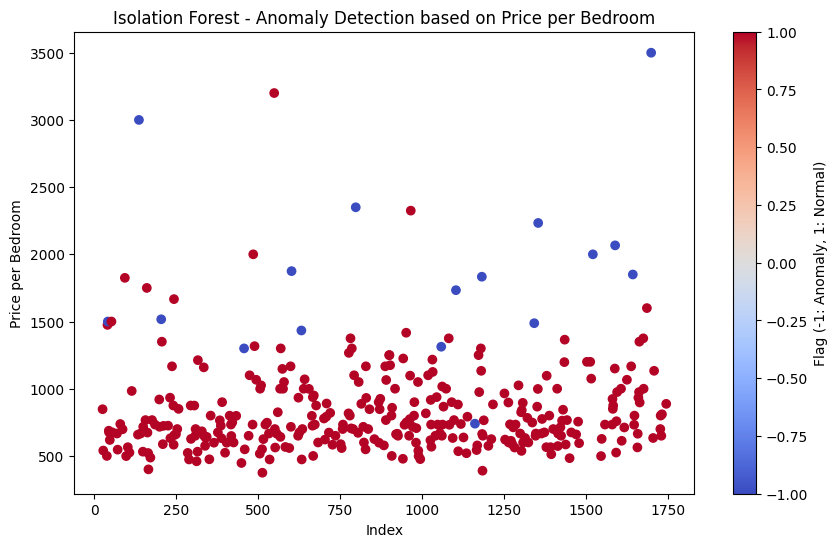

In [101]:
# Isolation Forest Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['Price per Bedroom'], 
            c=final_df['isolation_forest_flag'], cmap='coolwarm', label='Anomaly Score')
plt.title('Isolation Forest - Anomaly Detection based on Price per Bedroom')
plt.xlabel('Index')
plt.ylabel('Price per Bedroom')
plt.colorbar(label='Flag (-1: Anomaly, 1: Normal)')
plt.show()


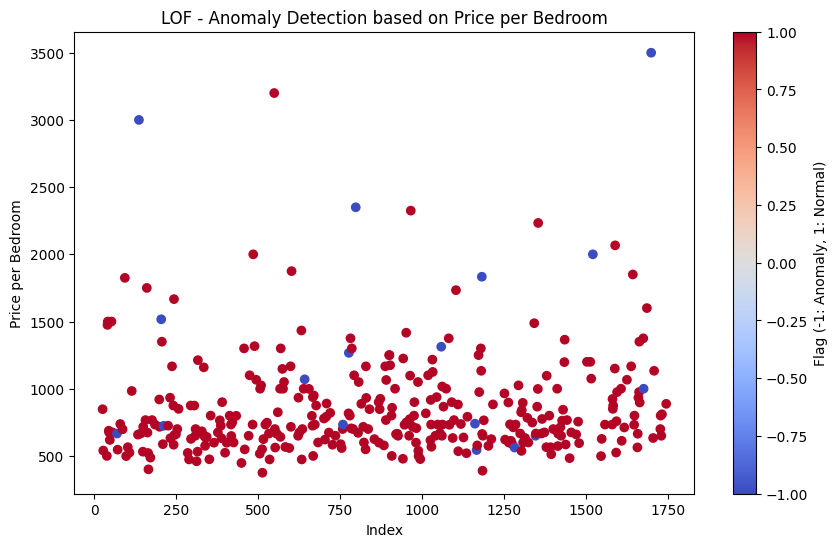

In [102]:
# LOF Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['Price per Bedroom'], 
            c=final_df['lof_flag'], cmap='coolwarm', label='Anomaly Score')
plt.title('LOF - Anomaly Detection based on Price per Bedroom')
plt.xlabel('Index')
plt.ylabel('Price per Bedroom')
plt.colorbar(label='Flag (-1: Anomaly, 1: Normal)')
plt.show()


In [79]:
'''# XGBoost Probability Scatter Plot
xgboost_probs = xgb_model.predict(dtrain)

plt.figure(figsize=(10, 6))
plt.scatter(final_training_set.index, xgboost_probs, c=(xgboost_probs > 0.5).astype(int), cmap='coolwarm')
plt.title('XGBoost - Predicted Anomaly Probabilities')
plt.xlabel('Index')
plt.ylabel('Anomaly Probability')
plt.colorbar(label='Flag (1: Anomaly, 0: Normal)')
plt.show()'''


"# XGBoost Probability Scatter Plot\nxgboost_probs = xgb_model.predict(dtrain)\n\nplt.figure(figsize=(10, 6))\nplt.scatter(final_training_set.index, xgboost_probs, c=(xgboost_probs > 0.5).astype(int), cmap='coolwarm')\nplt.title('XGBoost - Predicted Anomaly Probabilities')\nplt.xlabel('Index')\nplt.ylabel('Anomaly Probability')\nplt.colorbar(label='Flag (1: Anomaly, 0: Normal)')\nplt.show()"

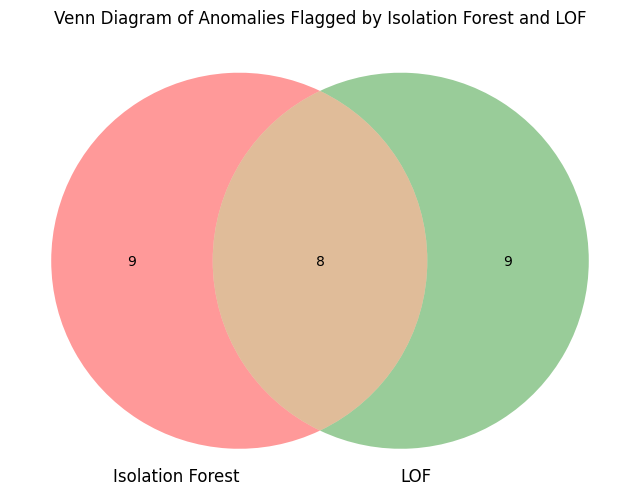

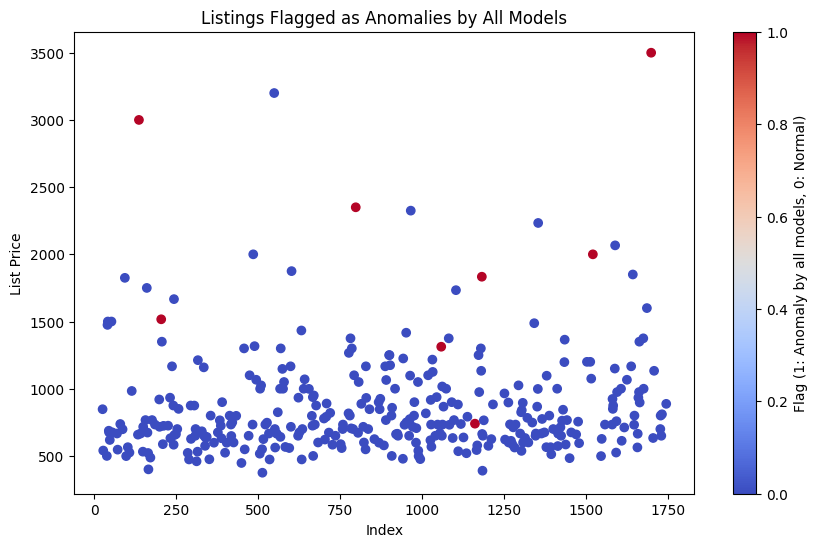

In [103]:
from matplotlib_venn import venn2

# Count how many were flagged by each model
isolation_flags = set(final_df.index[final_df['isolation_forest_flag'] == -1])
lof_flags = set(final_df.index[final_df['lof_flag'] == -1])

# Create a Venn diagram comparing the results of Isolation Forest and LOF
plt.figure(figsize=(8, 8))
venn = venn2([isolation_flags, lof_flags], 
             set_labels=('Isolation Forest', 'LOF'))

plt.title('Venn Diagram of Anomalies Flagged by Isolation Forest and LOF')
plt.show()
plt.figure(figsize=(10, 6))
plt.scatter(final_df.index, final_df['Price per Bedroom'], 
            c=final_df['flagged_by_all'], cmap='coolwarm')
plt.title('Listings Flagged as Anomalies by All Models')
plt.xlabel('Index')
plt.ylabel('List Price')
plt.colorbar(label='Flag (1: Anomaly by all models, 0: Normal)')
plt.show()



In [104]:
# Get the indices of listings flagged as anomalies by either Isolation Forest or LOF
anomalies_by_either = isolation_flags.union(lof_flags)
anomalies_by_either_list = list(anomalies_by_either)

# Filter the DataFrame to get the listings marked as anomalies by either model
anomalous_listings = final_df.loc[anomalies_by_either_list]

# Print the listings marked as anomalies by either model
print("Listings flagged as anomalies by either Isolation Forest or LOF:")
print(anomalous_listings)

Listings flagged as anomalies by either Isolation Forest or LOF:
      Under_30_Days_Flag  Distance Suspiciousness  Price per Bedroom  \
642                    0                 1.086615        1070.000000   
1283                   0                 1.039782         562.500000   
1347                   0                 0.901040         650.000000   
69                     1                 0.176185         666.666667   
136                    0                 0.983297        3000.000000   
457                    1                 0.924298        1300.000000   
1162                   0                 1.103318         740.000000   
1355                   0                 1.005467        2233.333333   
204                    1                 0.924919        1516.666667   
777                    1                 1.120380        1266.666667   
1677                   1                 0.283721        1000.000000   
1167                   1                 0.965418         543.750000   

(340, 14)


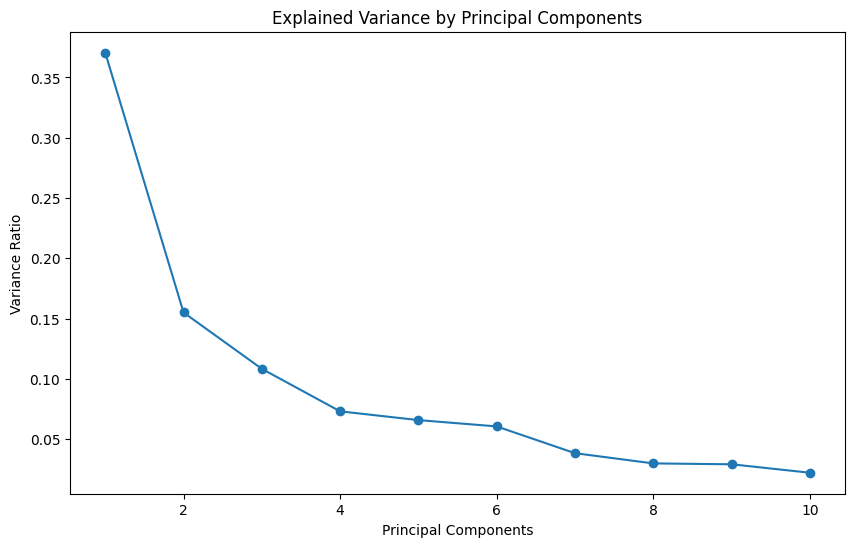

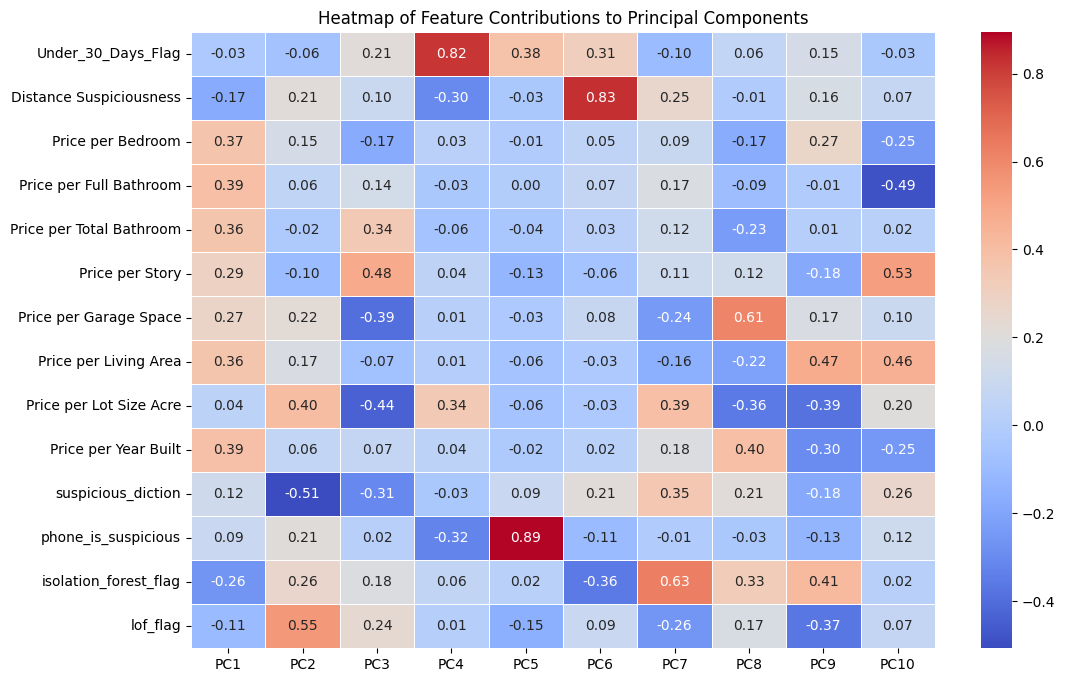

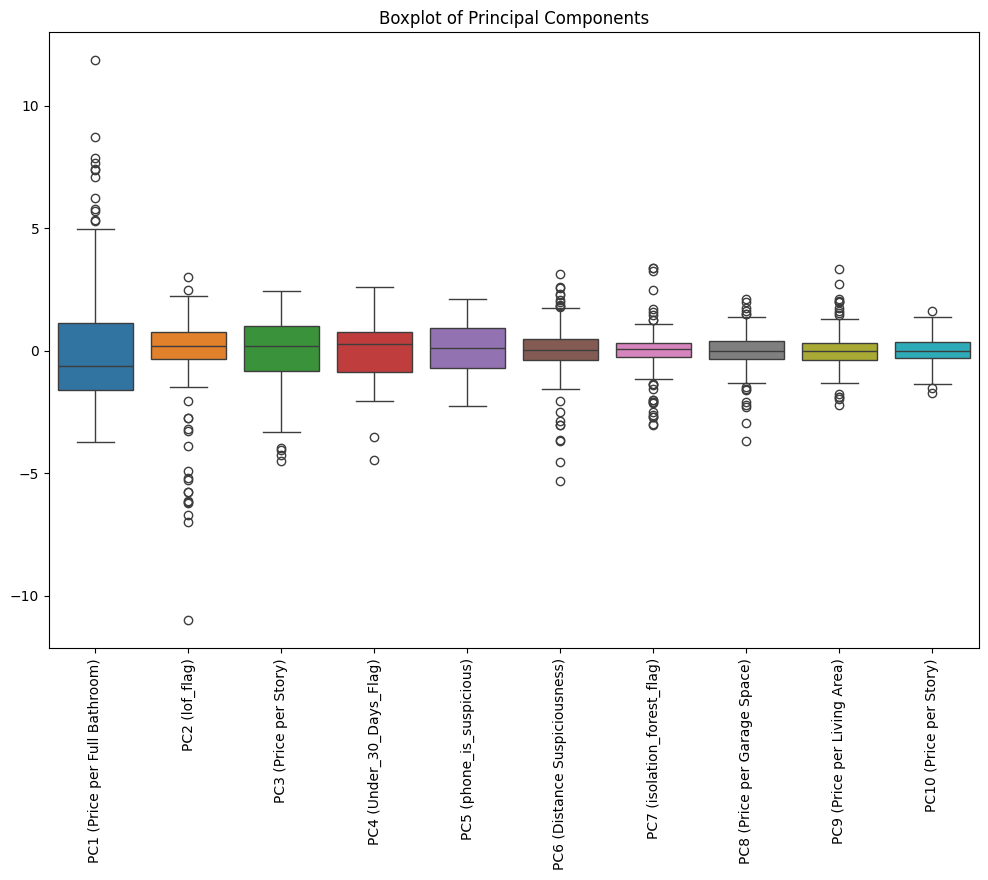

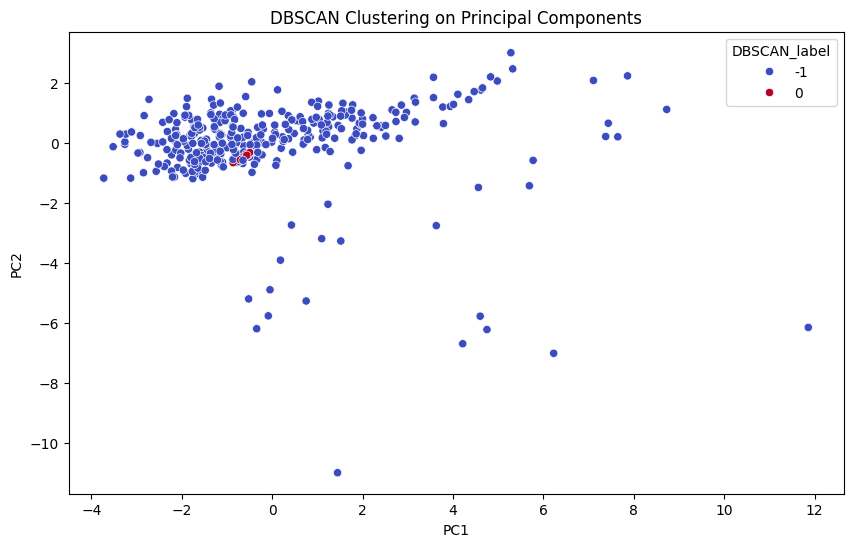

In [82]:

# Assuming final_df is your updated DataFrame
# Step 1: Select only the numerical features from final_df for PCA
numeric_features = final_df.select_dtypes(include=['float64', 'int64']).columns

# Step 2: Extract the numeric features from final_df
X = final_df[numeric_features].values

# Step 3: Standardize the numeric features before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check the shape of X_scaled to confirm preprocessing
print(X_scaled.shape)

# Step 4: Apply PCA, retaining 95% of the variance
pca = PCA(n_components=0.95)  # Retaining 95% variance

x_pca = pca.fit_transform(X_scaled)  # Perform PCA on scaled data

# Step 5: Create a DataFrame for the PCA-transformed data
pca_columns = [f'PC{i+1}' for i in range(x_pca.shape[1])]

# Get the top contributing features for each principal component
top_features_per_pc = []
for i in range(pca.components_.shape[0]):
    top_feature_index = np.argmax(np.abs(pca.components_[i]))
    top_feature = numeric_features[top_feature_index]
    top_features_per_pc.append(top_feature)

# Create more descriptive principal component labels
pca_columns_descriptive = [f'PC{i+1} ({top_features_per_pc[i]})' for i in range(len(pca_columns))]

pca_df = pd.DataFrame(x_pca, columns=pca_columns)

# Step 6: Visualize the explained variance for each principal component
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Components')
plt.ylabel('Variance Ratio')
plt.show()

# Step 4: Get the loadings (contributions) of each original feature to each principal component
loadings = pca.components_.T  # Transpose to get original features as rows
contributions_df = pd.DataFrame(loadings, index=numeric_features, columns=pca_columns)

# Step 5: Generate a heatmap of the contributions
plt.figure(figsize=(12, 8))
sns.heatmap(contributions_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Heatmap of Feature Contributions to Principal Components')
plt.show()

# Limit to a reasonable number of principal components (e.g., 10 for visualization)
pca_df_limited = pca_df.iloc[:, :17]

# Generate the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=pca_df_limited)

# Fix the xticks and labels
plt.title('Boxplot of Principal Components')
plt.xticks(rotation=90, ticks=np.arange(len(pca_df_limited.columns)), labels=pca_columns_descriptive[:17])
plt.show()


# # Step 6: Boxplot for each principal component
# plt.figure(figsize=(12, 8))
# # pca_df.boxplot()
# sns.boxplot(data=pca_df)

# plt.title('Boxplot of Principal Components')
# plt.xticks(rotation=90, ticks=np.arange(1, len(pca_columns_descriptive) + 1), labels=pca_columns_descriptive)
# plt.show()

#Step 7: Perform DBSCAN on the PCA-transformed data
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can adjust eps and min_samples based on your data
dbscan_labels = dbscan.fit_predict(x_pca)

# Step 8: Add the DBSCAN labels to the PCA DataFrame
pca_df['DBSCAN_label'] = dbscan_labels

# Step 9: Visualize the DBSCAN results using a scatter plot of the first two principal components
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_label', data=pca_df, palette='coolwarm')
plt.title('DBSCAN Clustering on Principal Components')
plt.show()

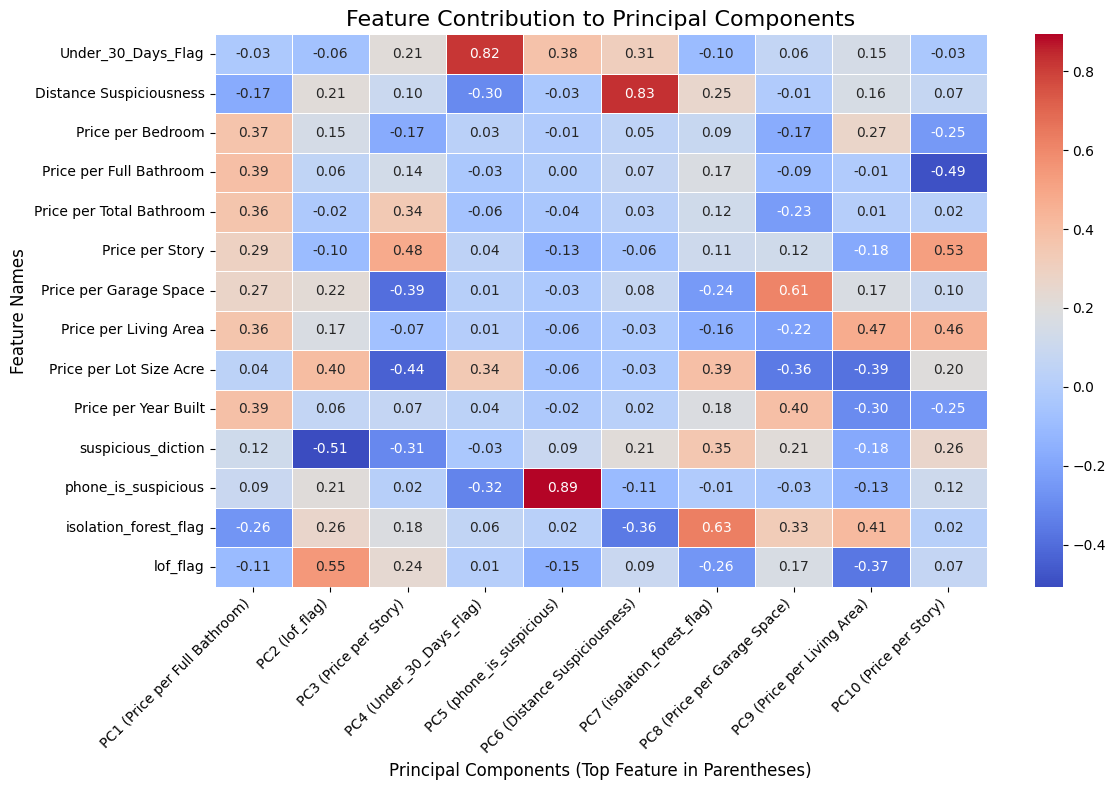

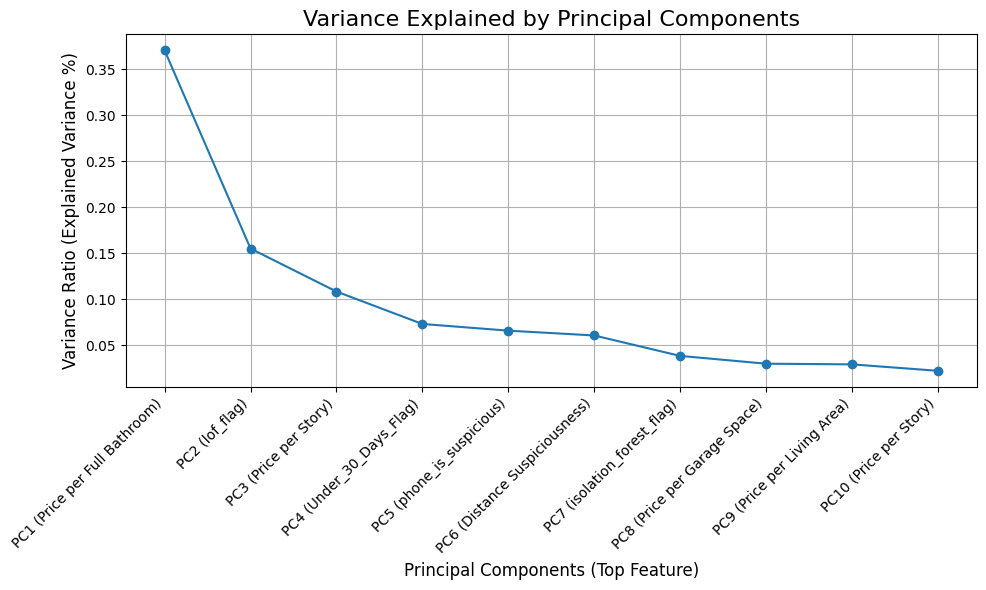

In [83]:
# Get the top contributing features for each principal component
top_features_per_pc = []
for i in range(pca.components_.shape[0]):
    top_feature_index = np.argmax(np.abs(pca.components_[i]))
    top_feature = numeric_features[top_feature_index]
    top_features_per_pc.append(top_feature)

# Create more descriptive principal component labels
pca_columns_descriptive = [f'PC{i+1} ({top_features_per_pc[i]})' for i in range(len(pca_columns))]

# Update the heatmap with descriptive labels
plt.figure(figsize=(12, 8))
sns.heatmap(contributions_df, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Feature Contribution to Principal Components', fontsize=16)
plt.xlabel('Principal Components (Top Feature in Parentheses)', fontsize=12)
plt.ylabel('Feature Names', fontsize=12)
plt.xticks(ticks=np.arange(len(pca_columns_descriptive)) + 0.5, labels=pca_columns_descriptive, rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Use descriptive labels for the principal components in the explained variance plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Variance Explained by Principal Components', fontsize=16)
plt.xlabel('Principal Components (Top Feature)', fontsize=12)
plt.ylabel('Variance Ratio (Explained Variance %)', fontsize=12)
plt.xticks(ticks=np.arange(1, len(pca_columns_descriptive) + 1), labels=pca_columns_descriptive, rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()  # Ensure layout doesn't overlap
plt.show()



In [105]:
def estimate_financial_damage(anomalies_df, precision=0.8, scam_success_rate=0.5):
    """
    Estimate financial damages caused by scams based on anomalies.

    Parameters:
    anomalies_df (DataFrame): The dataframe of detected anomalies.
    precision (float): The precision rate of actual scams within anomalies (default=0.8).
    scam_success_rate (float): The success rate of scams succeeding (default=0.5).

    Returns:
    float: Estimated financial damages.
    """
    # Calculate the estimated number of actual scams
    estimated_scams = len(anomalies_df) * precision * scam_success_rate
    
    # Calculate the mean price of the anomalies
    mean_price = anomalies_df['Price per Story'].mean()
    
    # Estimate total financial damage
    estimated_damage = estimated_scams * mean_price
    
    return estimated_damage

In [107]:
estimate_financial_damage(anomalous_listings)



np.float64(33973.66666666667)

In [108]:
len(anomalous_listings)

26

In [86]:
anomalous_listings.sort_values(by = "Distance Suspiciousness", ascending=False)

,Under_30_Days_Flag,Distance Suspiciousness,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built,suspicious_diction,phone_is_suspicious,isolation_forest_flag,lof_flag,flagged_by_all
160,0,1.327113,7.467371,7.467371,7.467371,7.467371,6.774224,0.425959,9.785705,-0.137025,0,0,1,-1,False
1589,1,1.319903,7.047517,7.047517,7.047517,7.047517,6.354370,0.362905,5.791901,-0.538272,0,1,-1,-1,True
211,1,1.140755,6.584446,6.872128,6.584446,7.277593,7.277593,0.163637,9.685539,0.365348,1,0,1,-1,False
952,0,1.125274,7.256062,7.661527,7.661527,8.354674,7.661527,0.544322,6.968380,0.766351,0,0,-1,1,False
777,1,1.120380,7.144144,7.549609,7.144144,8.242756,7.549609,0.427953,9.264408,0.630914,1,1,-1,-1,True
1162,0,1.103318,6.606650,7.522941,7.522941,8.216088,7.522941,0.296513,9.776736,0.603257,1,0,-1,-1,True
642,0,1.086615,6.975414,6.975414,6.975414,6.975414,7.668561,0.174687,9.785705,0.063667,1,0,1,-1,False
1283,0,1.039782,6.332391,7.025538,7.025538,7.718685,7.025538,0.413497,-0.983825,0.106349,1,0,-1,-1,True
1355,0,1.005467,7.711251,7.711251,7.423568,7.711251,8.809863,1.161123,12.028739,1.222046,0,1,-1,1,False
1183,0,0.999593,7.513891,7.513891,7.513891,6.127597,8.612503,1.046192,13.217674,1.009104,0,1,-1,1,False


In [87]:
features_for_detection = final_df.columns
features_for_detection

print(final_df['Under_30_Days_Flag'])

25      0
27      0
38      0
40      1
41      1
       ..
1728    0
1729    0
1731    0
1733    0
1746    0
Name: Under_30_Days_Flag, Length: 340, dtype: int64


In [88]:
'''
# Prepare the data for anomaly detection (select relevant columns)
# Assuming df_price_metrics is the DataFrame with price metrics
features_for_detection = final_df.columns

# Fill NaN values with the median of each column (or another appropriate strategy)
features_for_detection = features_for_detection.fillna(features_for_detection.median())

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination rate
iso_forest.fit(features_for_detection)

# Get anomaly scores (-1 means anomaly)
anomaly_labels = iso_forest.predict(features_for_detection)
df_price_metrics['Anomaly'] = anomaly_labels

# Filter out anomalies (scam candidates)
anomalous_listings = df_price_metrics[df_price_metrics['Anomaly'] == -1]

# Display the anomalies
print(f"Number of anomalies detected: {len(anomalous_listings)}")
anomalous_listings.head()
'''

# Select only numerical columns for the anomaly detection
numerical_features = final_df.select_dtypes(include=[np.number])

# Fill NaN values with the median of each column (or another appropriate strategy)
numerical_features = numerical_features.fillna(numerical_features.median())

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical data and transform it
scaled_features = scaler.fit_transform(numerical_features)

# Convert the scaled features back to a DataFrame and assign column names
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)

# Replace the original numerical features in final_df with the scaled ones
final_df[numerical_features.columns] = scaled_df

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination rate
iso_forest.fit(numerical_features)

# Get anomaly scores (-1 means anomaly)
anomaly_labels = iso_forest.predict(numerical_features)
final_df['Anomaly'] = anomaly_labels

# Filter out anomalies (scam candidates)

# Display the anomalies
print(f"Number of anomalies detected: {len(anomalous_listings)}")
anomalous_listings


Number of anomalies detected: 27


,Under_30_Days_Flag,Distance Suspiciousness,Price per Bedroom,Price per Full Bathroom,Price per Total Bathroom,Price per Story,Price per Garage Space,Price per Living Area,Price per Lot Size Acre,Price per Year Built,suspicious_diction,phone_is_suspicious,isolation_forest_flag,lof_flag,flagged_by_all
642,0,1.086615,6.975414,6.975414,6.975414,6.975414,7.668561,0.174687,9.785705,0.063667,1,0,1,-1,False
1283,0,1.039782,6.332391,7.025538,7.025538,7.718685,7.025538,0.413497,-0.983825,0.106349,1,0,-1,-1,True
1347,0,0.901040,6.476972,6.764654,6.764654,7.170120,7.170120,0.006560,9.578065,0.255885,1,0,1,-1,False
69,1,0.176185,6.502290,6.907755,6.907755,7.600902,6.907755,0.223144,9.070578,-0.010940,0,1,1,-1,False
136,0,0.983297,8.006368,8.006368,8.006368,8.006368,8.699515,1.588003,9.785705,1.106141,0,0,-1,1,False
457,1,0.924298,7.170120,7.680945,7.680945,8.779557,7.863267,0.672440,10.088891,1.169695,0,0,-1,1,False
777,1,1.120380,7.144144,7.549609,7.144144,8.242756,7.549609,0.427953,9.264408,0.630914,1,1,-1,-1,True
1162,0,1.103318,6.606650,7.522941,7.522941,8.216088,7.522941,0.296513,9.776736,0.603257,1,0,-1,-1,True
204,1,0.924919,7.324270,7.324270,7.036588,7.729735,7.729735,0.294297,10.630157,0.814012,1,1,-1,-1,True
1355,0,1.005467,7.711251,7.711251,7.423568,7.711251,8.809863,1.161123,12.028739,1.222046,0,1,-1,1,False


In [89]:
from sklearn.preprocessing import MinMaxScaler

# Re-apply Min-Max Scaling on the numerical columns (excluding irrelevant ones)
min_max_scaler = MinMaxScaler()

# Fit the scaler and transform the clean numerical data
scaled_data_min_max = min_max_scaler.fit_transform(numerical_features)

# Convert the scaled data back to a DataFrame for easier manipulation
scaled_df_min_max = pd.DataFrame(scaled_data_min_max, columns=numerical_columns)

# Fit the Isolation Forest model on the Min-Max scaled data
iso_forest_min_max = IsolationForest(contamination=0.05, random_state=42)
iso_forest_min_max.fit(scaled_df_min_max)

# Get anomaly labels (-1 means anomaly)
anomaly_labels_min_max = iso_forest_min_max.predict(scaled_df_min_max)

# Adding the anomaly labels to the original dataframe
final_df['Anomaly'] = anomaly_labels_min_max

# Filter out anomalies (scam candidates)
anomalous_listings_min_max = final_df[final_df['Anomaly'] == -1]

# Displaying the number of anomalies and first few anomalous rows
len(anomalous_listings_min_max), anomalous_listings_min_max.head()


ValueError: Shape of passed values is (340, 14), indices imply (340, 17)

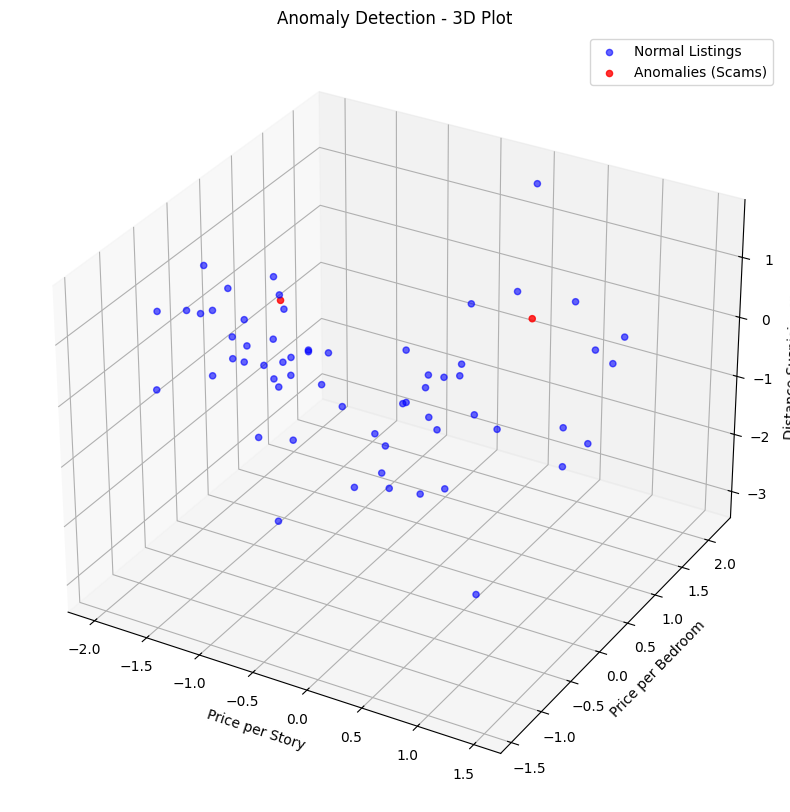

In [42]:
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot normal listings
ax.scatter(final_df[final_df['Anomaly'] == 1]['Price per Story'],
           final_df[final_df['Anomaly'] == 1]['Price per Bedroom'],
           final_df[final_df['Anomaly'] == 1]['Distance Suspiciousness'],
           c='blue', label='Normal Listings', alpha=0.6)

# Plot anomalous listings
ax.scatter(final_df[final_df['Anomaly'] == -1]['Price per Story'],
           final_df[final_df['Anomaly'] == -1]['Price per Bedroom'],
           final_df[final_df['Anomaly'] == -1]['Distance Suspiciousness'],
           c='red', label='Anomalies (Scams)', alpha=0.8)

# Labeling
ax.set_title('Anomaly Detection - 3D Plot')
ax.set_xlabel('Price per Story')
ax.set_ylabel('Price per Bedroom')
ax.set_zlabel('Distance Suspiciousness')

plt.legend()
plt.show()


In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# Assuming 'final_df' is your DataFrame with all the features
# Select only numerical columns for scaling
# Select only numerical columns for the anomaly detection

# Initialize StandardScaler
scaler = StandardScaler()

# Fit the scaler on the numerical data and transform it
scaled_features = scaler.fit_transform(numerical_features)

# Convert the scaled features back to a DataFrame and assign column names
scaled_df = pd.DataFrame(scaled_features, columns=numerical_features.columns)

# Replace the original numerical features in final_df with the scaled ones
final_df[numerical_features.columns] = scaled_df

# Now, final_df is standardized and ready for training with Isolation Forest

# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Fit the model on the standardized data
iso_forest.fit(final_df.select_dtypes(include=[np.number]))

# Predict anomalies (-1 means anomaly, 1 means normal)
anomaly_labels = iso_forest.predict(final_df.select_dtypes(include=[np.number]))

# Add the anomaly labels to the DataFrame
final_df['Anomaly'] = anomaly_labels

# Filter out the anomalies (scam candidates)
anomalous_listings = final_df[final_df['Anomaly'] == -1]

# Display the anomalies
print(f"Number of anomalies detected: {len(anomalous_listings)}")
print(anomalous_listings.head())


ValueError: Input X contains NaN.
IsolationForest does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values